In [1]:
import torch
import torch.autograd
import numpy as np
import matplotlib.pyplot as plt
from numml.torch.sparse import SparseCSRTensor

In [2]:
# Our example triangular system
A = np.eye(5)*2 - np.eye(5,k=-1)
A

array([[ 2.,  0.,  0.,  0.,  0.],
       [-1.,  2.,  0.,  0.,  0.],
       [ 0., -1.,  2.,  0.,  0.],
       [ 0.,  0., -1.,  2.,  0.],
       [ 0.,  0.,  0., -1.,  2.]])

In [3]:
# switch this to False to test upper triangular
lower = True

In [4]:
# Convert to torch tensor type
A_T = torch.tensor(A).float()
if not lower:
    A_T = A_T.T
A_T

tensor([[ 2.,  0.,  0.,  0.,  0.],
        [-1.,  2.,  0.,  0.,  0.],
        [ 0., -1.,  2.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0., -1.,  2.]])

In [5]:
# Create CSR representation of A_T, and enable gradient on its data
A_csr = SparseCSRTensor(A_T)
A_csr.data.requires_grad = True

In [6]:
# Generate right-hand-side
b = torch.arange(5).float() + 1.
b

tensor([1., 2., 3., 4., 5.])

In [7]:
# Solve Ax=b for x
x = A_csr.solve_triangular(upper=(not lower), unit=False, b=b)
x

tensor([0.5000, 1.2500, 2.1250, 3.0625, 4.0312],
       grad_fn=<ScaleVecPrimitiveBackward>)

In [8]:
# Assert that we have zero residual (A times x is equal to b)
torch.all((A_csr@x).detach() == b)

tensor(True)

In [9]:
# Interesting example:
# optimize the entries of A such that A^{-1} b = b

optimizer = torch.optim.Adam([A_csr.data], lr=0.01)
lh = []

for i in range(1_000):
    optimizer.zero_grad()
    
    x = A_csr.solve_triangular(upper=(not lower), unit=False, b=b)
    loss = torch.sum((x - b) ** 2)
    loss.backward()
    
    optimizer.step()
    
    lh.append(loss.item())
    if i % 100 == 0:
        print(i, loss.item())

0 3.3955078125
100 0.032617662101984024
200 2.1106672647874802e-05
300 2.89418267129804e-10
400 1.3216094885137863e-12
500 1.3216094885137863e-12
600 8.100187187665142e-13
700 8.100187187665142e-13
800 8.100187187665142e-13
900 5.115907697472721e-13


Text(0.5, 1.0, 'Loss history')

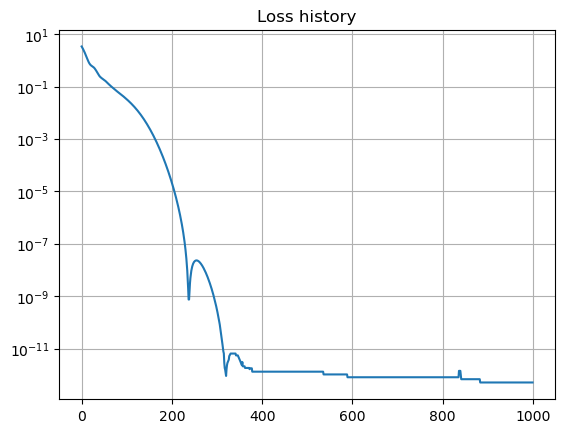

In [10]:
plt.semilogy(lh)
plt.grid()
plt.title('Loss history')

In [11]:
A_csr.to_dense()

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.3166,  1.6583,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -1.1963,  1.7976,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -1.1423,  1.8567,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -1.1120,  1.8896]], grad_fn=<CopySlices>)

In [12]:
A_csr.solve_triangular(upper=(not lower), unit=False, b=b)

tensor([1.0000, 2.0000, 3.0000, 4.0000, 5.0000],
       grad_fn=<ScaleVecPrimitiveBackward>)